In [24]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
)

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

sns.set_theme(style="whitegrid", context="notebook")

In [25]:
RANDOM_STATE = 42
TARGET_COL = "Diagnosis"
LFT_FEATURE = "LiverFunctionTest"

DATA_PATH = Path("../data/Liver_disease_data.csv")

In [26]:
df = pd.read_csv(DATA_PATH)
df.head()

,Age,Gender,BMI,AlcoholConsumption,Smoking,GeneticRisk,PhysicalActivity,Diabetes,Hypertension,LiverFunctionTest,Diagnosis
0,58,0,35.857584,17.272828,0,1,0.658940,0,0,42.734240,1
1,71,1,30.732470,2.201266,0,1,1.670557,1,0,67.309822,1
2,48,0,19.971407,18.500944,0,0,9.928308,0,0,63.738956,0
3,34,1,16.615417,12.632870,0,0,5.630129,0,0,64.555873,1
4,62,1,16.065830,1.087815,0,1,3.566218,1,0,77.868689,1


In [27]:
y = df[TARGET_COL]
if set(np.unique(y)) == {1, 2}:
    y = y.map({1:1, 2:0}).astype(int)
else:
    y = y.astype(int)

X = df.drop(columns=[TARGET_COL])

X.shape, y.shape, y.value_counts()

((1700, 10),
 (1700,),
 Diagnosis
 1    936
 0    764
 Name: count, dtype: int64)

In [28]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1765, stratify=y_trainval, random_state=RANDOM_STATE
)

X_train.shape, X_val.shape, X_test.shape

((1189, 10), (256, 10), (255, 10))

In [29]:
def build_preprocessor(X_ref):
    numeric_cols = X_ref.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = [c for c in X_ref.columns if c not in numeric_cols]

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    return ColumnTransformer([
        ("numeric", numeric_transformer, numeric_cols),
        ("categorical", categorical_transformer, categorical_cols)
    ], remainder="drop")

In [30]:
def build_pipeline(X_ref, estimator):
    return Pipeline([
        ("preprocessor", build_preprocessor(X_ref)),
        ("model", estimator)
    ])

In [31]:
def evaluate(pipeline, X_eval, y_eval):
    preds = pipeline.predict(X_eval)
    probs = pipeline.predict_proba(X_eval)[:, 1] if hasattr(pipeline.named_steps["model"], "predict_proba") else np.zeros(len(y_eval))
    return {
        "Accuracy": accuracy_score(y_eval, preds),
        "Precision": precision_score(y_eval, preds),
        "Recall": recall_score(y_eval, preds),
        "F1-score": f1_score(y_eval, preds),
        "ROC-AUC": roc_auc_score(y_eval, probs)
    }, preds, probs

In [32]:
def run_grid(name, estimator, param_grid, X_tr, y_tr, X_va, y_va, seed=RANDOM_STATE):
    pipe = build_pipeline(X_tr, estimator)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    gs = GridSearchCV(pipe, param_grid=param_grid, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True)
    gs.fit(X_tr, y_tr)
    metrics_val, pred_val, proba_val = evaluate(gs.best_estimator_, X_va, y_va)
    res = {"name": name, "best_params": gs.best_params_, **metrics_val}
    return gs.best_estimator_, res, (pred_val, proba_val)

In [33]:
log_reg = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)
log_grid = {
    "model__penalty": ["l2"],
    "model__C": [0.1, 1.0, 3.0, 10.0],
    "model__solver": ["lbfgs", "liblinear"],
    "model__class_weight": [None, "balanced"]
}

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=RANDOM_STATE,
    n_jobs=-1
)
xgb_grid = {
    "model__n_estimators": [100, 300, 600],
    "model__max_depth": [2, 3, 5],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
    "model__reg_lambda": [1.0, 2.0, 5.0]
}

In [34]:
all_features = X.columns.tolist()
features_without_lft = [c for c in X.columns if c != LFT_FEATURE]

Xtr_WITH,  Xva_WITH  = X_train[all_features],     X_val[all_features]
Xtr_WITHOUT, Xva_WITHOUT = X_train[features_without_lft], X_val[features_without_lft]

In [35]:
experiments = []

best_LR_WITH, res_LR_WITH, _ = run_grid(
    "LogisticRegression SA LiverFunctionTest",
    log_reg, log_grid,
    Xtr_WITH, y_train, Xva_WITH, y_val
)
experiments.append((best_LR_WITH, res_LR_WITH))
res_LR_WITH

{'name': 'LogisticRegression SA LiverFunctionTest',
 'best_params': {'model__C': 0.1,
  'model__class_weight': 'balanced',
  'model__penalty': 'l2',
  'model__solver': 'lbfgs'},
 'Accuracy': 0.8203125,
 'Precision': 0.8740157480314961,
 'Recall': 0.7872340425531915,
 'F1-score': 0.8283582089552238,
 'ROC-AUC': 0.9203206907184704}

In [36]:
best_LR_WITHOUT, res_LR_WITHOUT, _ = run_grid(
    "LogisticRegression BEZ LiverFunctionTest",
    log_reg, log_grid,
    Xtr_WITHOUT, y_train, Xva_WITHOUT, y_val
)
experiments.append((best_LR_WITHOUT, res_LR_WITHOUT))
res_LR_WITHOUT

{'name': 'LogisticRegression BEZ LiverFunctionTest',
 'best_params': {'model__C': 0.1,
  'model__class_weight': 'balanced',
  'model__penalty': 'l2',
  'model__solver': 'lbfgs'},
 'Accuracy': 0.734375,
 'Precision': 0.792,
 'Recall': 0.7021276595744681,
 'F1-score': 0.7443609022556391,
 'ROC-AUC': 0.8378661732963306}

In [37]:
best_XGB_WITH, res_XGB_WITH, _ = run_grid(
    "XGBoost SA LiverFunctionTest",
    xgb, xgb_grid,
    Xtr_WITH, y_train, Xva_WITH, y_val
)
experiments.append((best_XGB_WITH, res_XGB_WITH))
res_XGB_WITH

{'name': 'XGBoost SA LiverFunctionTest',
 'best_params': {'model__colsample_bytree': 1.0,
  'model__learning_rate': 0.05,
  'model__max_depth': 2,
  'model__n_estimators': 300,
  'model__reg_lambda': 2.0,
  'model__subsample': 0.8},
 'Accuracy': 0.95703125,
 'Precision': 0.9779411764705882,
 'Recall': 0.9432624113475178,
 'F1-score': 0.9602888086642599,
 'ROC-AUC': 0.9670058587727413}

In [38]:
best_XGB_WITHOUT, res_XGB_WITHOUT, _ = run_grid(
    "XGBoost BEZ LiverFunctionTest",
    xgb, xgb_grid,
    Xtr_WITHOUT, y_train, Xva_WITHOUT, y_val
)
experiments.append((best_XGB_WITHOUT, res_XGB_WITHOUT))
res_XGB_WITHOUT

{'name': 'XGBoost BEZ LiverFunctionTest',
 'best_params': {'model__colsample_bytree': 0.8,
  'model__learning_rate': 0.1,
  'model__max_depth': 2,
  'model__n_estimators': 100,
  'model__reg_lambda': 5.0,
  'model__subsample': 0.8},
 'Accuracy': 0.76953125,
 'Precision': 0.7847222222222222,
 'Recall': 0.8014184397163121,
 'F1-score': 0.7929824561403509,
 'ROC-AUC': 0.883595436324391}

In [39]:
validation_results = pd.DataFrame([r for _, r in experiments]).sort_values("ROC-AUC", ascending=False)
validation_results = validation_results[["name","Accuracy","Precision","Recall","F1-score","ROC-AUC","best_params"]].round(3)
validation_results

,name,Accuracy,Precision,Recall,F1-score,ROC-AUC,best_params
2,XGBoost SA LiverFunctionTest,0.957,0.978,0.943,0.960,0.967,"{'model__colsample_bytree': 1.0, 'model__learn..."
0,LogisticRegression SA LiverFunctionTest,0.820,0.874,0.787,0.828,0.920,"{'model__C': 0.1, 'model__class_weight': 'bala..."
3,XGBoost BEZ LiverFunctionTest,0.770,0.785,0.801,0.793,0.884,"{'model__colsample_bytree': 0.8, 'model__learn..."
1,LogisticRegression BEZ LiverFunctionTest,0.734,0.792,0.702,0.744,0.838,"{'model__C': 0.1, 'model__class_weight': 'bala..."


<Figure size 700x600 with 0 Axes>

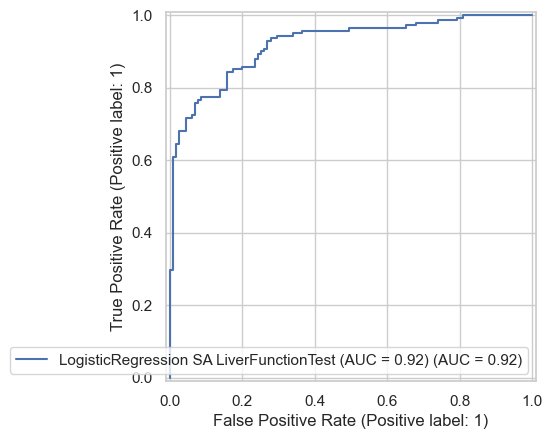

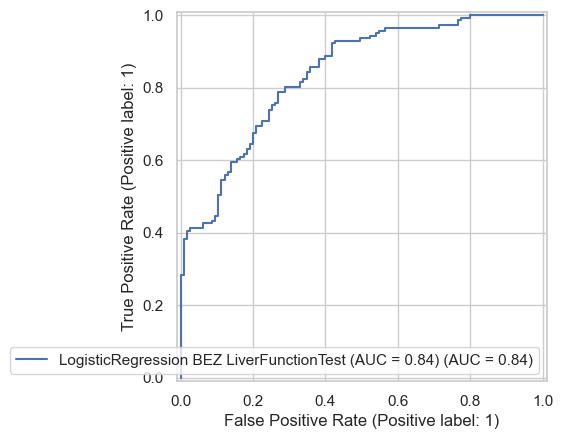

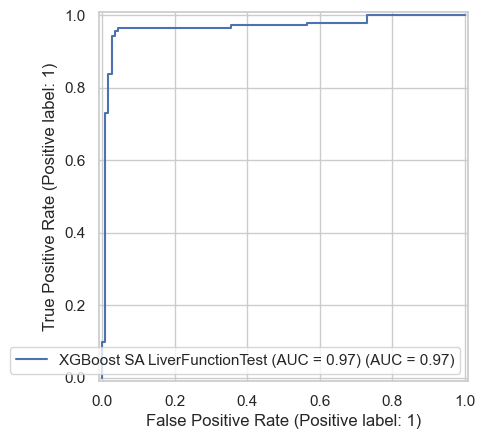

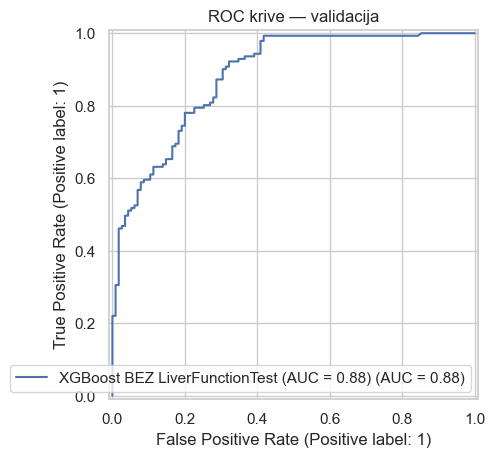

In [40]:
plt.figure(figsize=(7,6))
for est, r in experiments:
    with_lft = "SA LiverFunctionTest" in r["name"]
    feats = all_features if with_lft else features_without_lft
    probs = est.predict_proba(X_val[feats])[:, 1]
    RocCurveDisplay.from_predictions(y_val, probs, name=f"{r['name']} (AUC = {roc_auc_score(y_val, probs):.2f})")
plt.title("ROC krive — validacija")
plt.grid(True)
plt.show()

In [41]:
best_row = validation_results.iloc[0]
best_name = best_row["name"]
best_idx = [i for i, (_, r) in enumerate(experiments) if r["name"] == best_name][0]
final_model = experiments[best_idx][0]
final_features = all_features if "SA LiverFunctionTest" in best_name else features_without_lft

X_train_plus_val = pd.concat([X_train[final_features], X_val[final_features]], axis=0)
y_train_plus_val = pd.concat([y_train, y_val], axis=0)
final_model.fit(X_train_plus_val, y_train_plus_val)

best_name, experiments[best_idx][1]["best_params"]

('XGBoost SA LiverFunctionTest',
 {'model__colsample_bytree': 1.0,
  'model__learning_rate': 0.05,
  'model__max_depth': 2,
  'model__n_estimators': 300,
  'model__reg_lambda': 2.0,
  'model__subsample': 0.8})

In [42]:
test_metrics, test_preds, test_probs = evaluate(final_model, X_test[final_features], y_test)
pd.DataFrame([test_metrics]).round(3)

,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,0.906,0.933,0.893,0.912,0.962


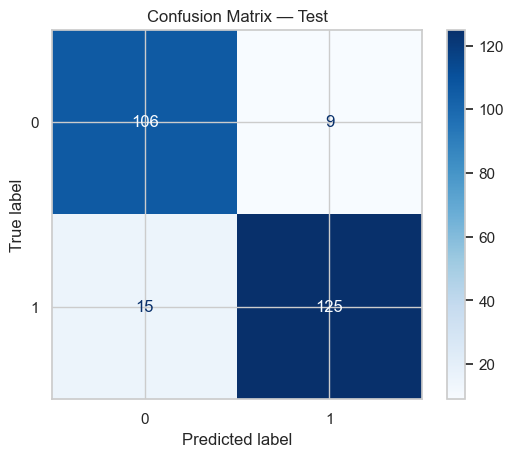

In [43]:
cm = confusion_matrix(y_test, test_preds)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix — Test")
plt.show()

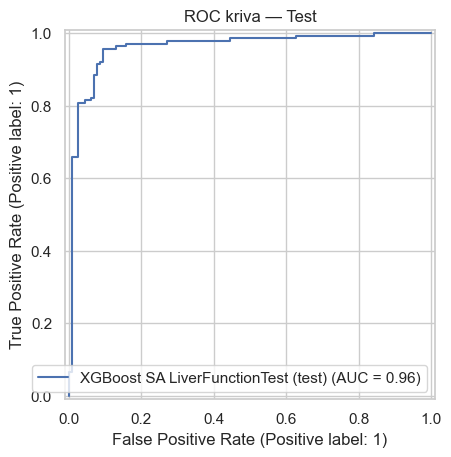

In [44]:
RocCurveDisplay.from_predictions(y_test, test_probs, name=f"{best_name} (test)")
plt.title("ROC kriva — Test")
plt.grid(True)
plt.show()

numeric__AlcoholConsumption    1.131827
numeric__LiverFunctionTest     1.076403
numeric__Smoking               0.675517
numeric__Gender                0.587747
numeric__Age                   0.521670
numeric__BMI                   0.517400
numeric__Hypertension          0.442306
numeric__GeneticRisk           0.420259
numeric__Diabetes              0.314286
numeric__PhysicalActivity      0.303916
dtype: float64

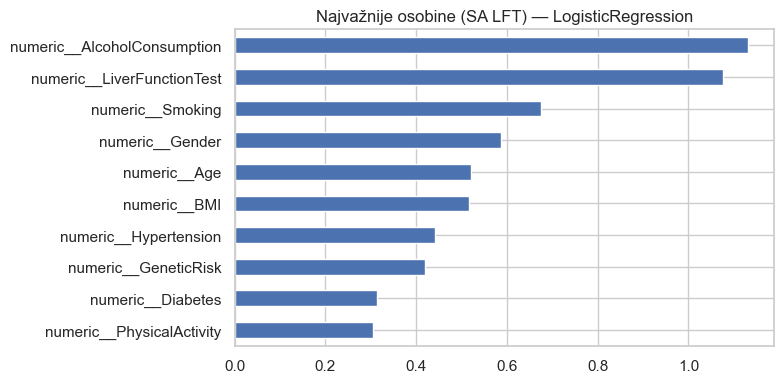

numeric__AlcoholConsumption    0.880602
numeric__Smoking               0.567705
numeric__Gender                0.516780
numeric__BMI                   0.468308
numeric__Hypertension          0.410321
numeric__Age                   0.404326
numeric__GeneticRisk           0.338873
numeric__PhysicalActivity      0.293658
numeric__Diabetes              0.269810
dtype: float64

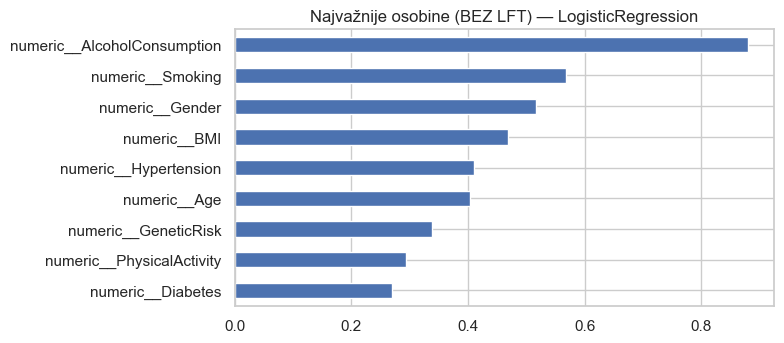

numeric__AlcoholConsumption    0.144949
numeric__LiverFunctionTest     0.143081
numeric__Smoking               0.110198
numeric__Gender                0.107698
numeric__GeneticRisk           0.100480
numeric__Hypertension          0.095339
numeric__Age                   0.091688
numeric__BMI                   0.077169
numeric__PhysicalActivity      0.072273
numeric__Diabetes              0.057125
dtype: float32

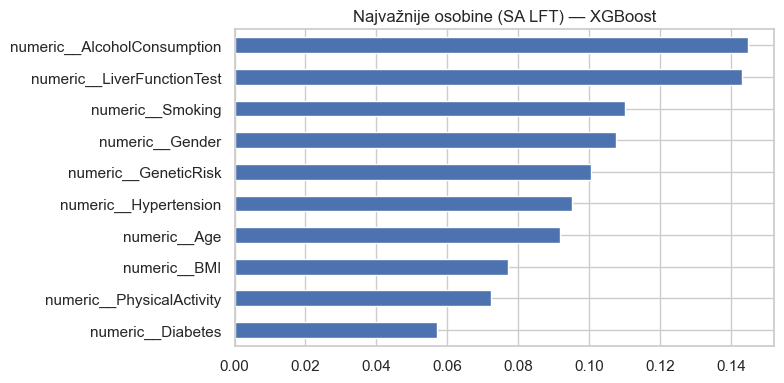

numeric__AlcoholConsumption    0.193376
numeric__Smoking               0.135842
numeric__Gender                0.135385
numeric__GeneticRisk           0.120320
numeric__Hypertension          0.108398
numeric__Age                   0.080017
numeric__PhysicalActivity      0.078541
numeric__BMI                   0.075816
numeric__Diabetes              0.072304
dtype: float32

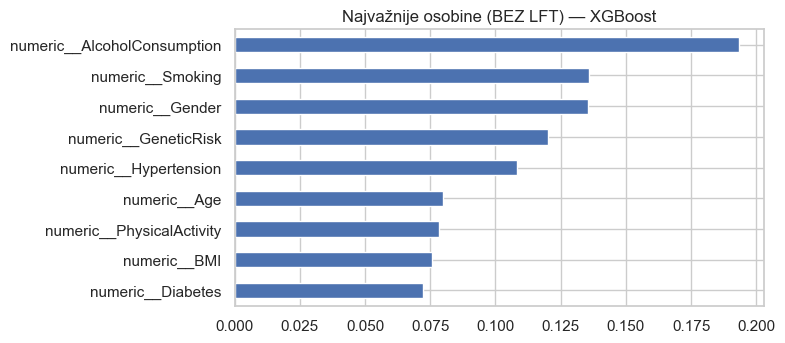

In [46]:
def show_importance(fitted_pipeline, title_prefix=""):
    feature_names = fitted_pipeline.named_steps["preprocessor"].get_feature_names_out()
    model = fitted_pipeline.named_steps["model"]
    if isinstance(model, LogisticRegression):
        values = np.abs(model.coef_[0])
        title = f"{title_prefix} — LogisticRegression"
    else:
        values = model.feature_importances_
        title = f"{title_prefix} — XGBoost"
    importance = pd.Series(values, index=feature_names).sort_values(ascending=False).head(12)
    display(importance)
    plt.figure(figsize=(8, max(3, 0.4*len(importance))))
    importance.sort_values().plot(kind="barh")
    plt.title(title)
    plt.tight_layout()
    plt.show()

name_to_est = {r["name"]: est for est, r in experiments}

show_importance(name_to_est["LogisticRegression SA LiverFunctionTest"],  "Najvažnije osobine (SA LFT)")
show_importance(name_to_est["LogisticRegression BEZ LiverFunctionTest"], "Najvažnije osobine (BEZ LFT)")
show_importance(name_to_est["XGBoost SA LiverFunctionTest"],            "Najvažnije osobine (SA LFT)")
show_importance(name_to_est["XGBoost BEZ LiverFunctionTest"],           "Najvažnije osobine (BEZ LFT)")

In [47]:
Path("models").mkdir(exist_ok=True, parents=True)
save_path = Path("models/best_liver_model.pkl")
joblib.dump(final_model, save_path)
str(save_path)

'models\\best_liver_model.pkl'

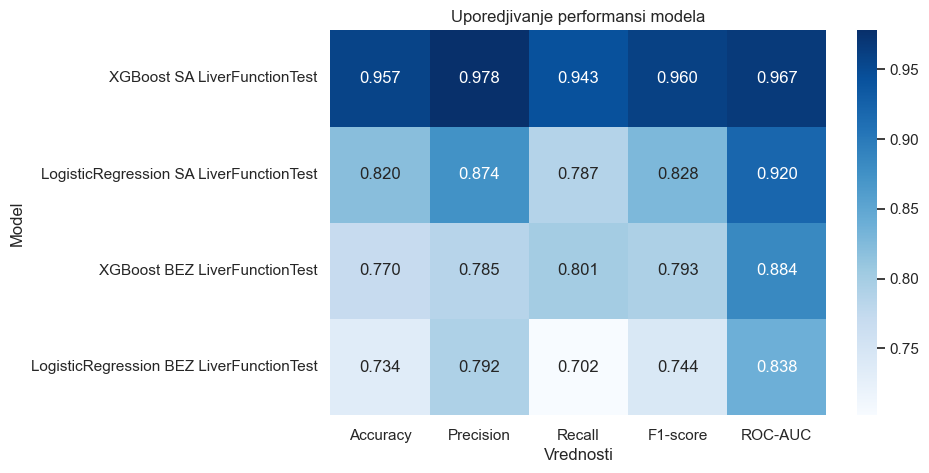

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.heatmap(
    validation_results.set_index("name").drop(columns=["best_params"]),
    annot=True, fmt=".3f", cmap="Blues", cbar=True
)
plt.title("Uporedjivanje performansi modela")
plt.ylabel("Model")
plt.xlabel("Vrednosti")
plt.show()